In [58]:
%matplotlib notebook
import numpy as np
import glob
import matplotlib.pyplot as plt
import copy
import plotly.graph_objects as go
import pywt

In [59]:
# define constants
NUM_OF_STAGES = 5
NUM_OF_BRAIN_WAVES = 8
TIME_STEP = 0.01
NUM_OF_INPUT = 3000
DWT_LEVEL = 4

In [60]:
def load_data():
    path_list = glob.glob('data_converted/*.npz')
    data_list = [np.load(path, allow_pickle=True) for path in path_list]
    return data_list

In [61]:
#group eeg signal according to stages
def group_data_by_stages(data_list):
    print("Running " + "group_data_by_stages()")
    signal_of_stages = [[] for i in range(NUM_OF_STAGES)]
    count = 1
    for data in data_list:
        for i in range(len(data['y'])):
            stage = data['y'][i]
            signal = data['x'][i].flatten()
            signal_of_stages[stage].append(signal)
        print(str(count*100//len(data_list)) + "%")
        count += 1
    for stage in range(NUM_OF_STAGES):
        signal_of_stages[stage] = np.asarray(signal_of_stages[stage])
    return signal_of_stages

In [62]:
#get average signal amplitudes of different stages
def get_stage_average_signal_amplitudes(signal_of_stages):
    average_amplitudes_of_stages = [0 for i in range(NUM_OF_STAGES)]
    for stage in range(NUM_OF_STAGES):
        average_amplitudes_of_stages[stage] = np.mean(np.abs(signal_of_stages[stage]))
    return average_amplitudes_of_stages

In [63]:
#get distribution of of signal amplitudes
def get_stage_amplitude_distribution(signal_of_stages):
    print("Running get_stage_amplitude_distribution")
    amplitude_distribution_of_stages = [{} for stage in range(NUM_OF_STAGES)]
    for stage in range(NUM_OF_STAGES):
        print(str(stage*100//NUM_OF_STAGES) + "%")
        for amplitude in signal_of_stages[stage].flatten():
            index = round(round(amplitude / 0.0005) * 0.0005, 4)
            if index not in amplitude_distribution_of_stages[stage].keys():
                amplitude_distribution_of_stages[stage][index] = 0
            amplitude_distribution_of_stages[stage][index] += 1 
    return amplitude_distribution_of_stages

In [64]:
#get fft magnitudes
def get_stage_fft_magnitudes(signal_of_stages):
    freqs = np.fft.fftfreq(NUM_OF_INPUT, TIME_STEP)
    freqs = freqs[:len(freqs)//2]
    
    fft_magnitudes_of_stages = [None for stage in range(NUM_OF_STAGES)]
    for stage in range(NUM_OF_STAGES):
        fft_magnitudes_of_stages[stage] = np.abs(np.fft.fft(signal_of_stages[stage]))[:len(freqs)]
    
    return freqs, fft_magnitudes_of_stages

In [65]:
#get average fft magnitudes of different stages
def get_stage_average_fft_magnitudes(fft_magnitudes_of_stages):
    average_fft_magnitudes_of_stages = [[] for stage in range(NUM_OF_STAGES)]
    for stage in range(NUM_OF_STAGES):
        average_fft_magnitudes_of_stages[stage] = np.mean(fft_magnitudes_of_stages[stage], axis=0)
    return average_fft_magnitudes_of_stages

In [66]:
#get average fft magnitudes for different brain waves
def get_brain_wave_average_fft_amplitude(average_fft_magnitudes_of_stages):
    
    def get_index_range(freq_l, freq_h):
        return int(freq_l / 50 * 3000), int(freq_h / 50 * 3000)
        
    DELTA_L, DELTA_H = 0.5, 4
    THETA_L, THETA_H = 4, 8
    ALPHA_L, ALPHA_H = 8, 12
    SIGMA_L, SIGMA_H = 12, 15
    BETA1_L, BETA1_H = 15, 22
    BETA2_L, BETA2_H = 22, 30
    GAMMA1_L, GAMMA1_H = 30, 40
    GAMMA2_L, GAMMA2_H = 40, 49.5
    
    brain_wave_ranges = np.array([DELTA_L, DELTA_H,
                                  THETA_L, THETA_H,
                                  ALPHA_L, ALPHA_H,
                                  SIGMA_L, SIGMA_H,
                                  BETA1_L, BETA1_H,
                                  BETA2_L, BETA2_H,
                                  GAMMA1_L, GAMMA1_H,
                                  GAMMA2_L, GAMMA2_H]).reshape(-1, 2)
    
    average_magnitudes_of_waves_of_stages = [[0 for j in range(NUM_OF_BRAIN_WAVES)] for i in range(NUM_OF_STAGES)]
    for stage in range(NUM_OF_STAGES):
        for i in range(brain_wave_ranges.shape[0]):
            index_l, index_h = get_index_range(brain_wave_ranges[i][0], brain_wave_ranges[i][1])
            average_magnitudes_of_waves_of_stages[stage][i] = np.mean(average_fft_magnitudes_of_stages[stage][index_l:index_h])
    
    brain_wave_labels = ['Delta(0.5-4hz)',
                         'Theta(4-8hz)',
                         'Alpha(8-12hz)',
                         'Sigma(12-15hz)',
                         'Beta1(15-22hz)',
                         'Beta2(22-30hz)',
                         'Gamma1(30-40hz)',
                         'Gamma2(40-49.5hz)']
    return brain_wave_labels, average_magnitudes_of_waves_of_stages

In [67]:
#get dwt coefficients for all signal
def get_dwt_coefficients(signal_of_stages):
    dwt_coefficients = [pywt.wavedec(signal_of_stages[stage], 'haar', level=DWT_LEVEL) for stage in range(NUM_OF_STAGES)]
    return dwt_coefficients

In [68]:
# ---------------------------------------------------------------------------

In [69]:
# EEG Fpz-Cz against time for one sleep
def plot_signal_for_one_sleep(data):
    num_of_stages = 5
    x_values = [i * 0.01 / 60 for i in range(len(data['x'])*len(data['x'][0]))]
    y_values_nested = data['x']
    
    stage_x_values = [x_values for j in range(num_of_stages)]
    stage_y_values_nested = [copy.deepcopy(y_values_nested) for j in range(num_of_stages)]
    
    for i in range(len(y_values_nested)):
        for j in range(num_of_stages):
            if j != data['y'][i]:
                stage_y_values_nested[j][i] = np.nan
    
    stage_y_values = [[] for i in range(num_of_stages)]
    for i in range(len(stage_y_values_nested)):
        for item in stage_y_values_nested[i]:
            stage_y_values[i].extend(item)

    for i in range(len(stage_x_values)):
        plt.plot(stage_x_values[i], stage_y_values[i], label='stage ' + str(i))
    
    subject_name = data['header_raw'].item()['local_subject_id']
    plt.title('EEG against time for ' + subject_name)
    plt.ylabel('EEG Fpz-Cz')
    plt.xlabel('Time/min')
    plt.legend(loc='upper center',  bbox_to_anchor=(0.5, 1.0), ncol=3)
    plt.show()

In [70]:
def compare_signals_of_different_stages(signal_of_stages, index):
    time = np.linspace(0, 3000*TIME_STEP, 3000)
    # plot using plotly
    fig = go.Figure()
    # Create and style traces
    for stage in range(NUM_OF_STAGES):
        fig.add_trace(go.Scatter(x=time, y=signal_of_stages[stage][index], name='Stage '+str(stage), mode='lines'))

    # Edit the layout
    fig.update_layout(title='Signal of different stages',
                      xaxis_title='Time/s',
                      yaxis_title='EEG Signal')
    fig.show()

In [71]:
def plot_average_signal_amplitudes_of_different_stages(average_amplitudes_of_stages):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=[stage for stage in range(NUM_OF_STAGES)],
                         y=average_amplitudes_of_stages))
    # Edit the layout
    fig.update_layout(title='Average signal amplitudes for all stages',
                      xaxis_title='Stage',
                      yaxis_title='Average Signal Amplitude')

    fig.show()


In [72]:
def plot_amplitude_distributions(amplitude_distribution_of_stages):
    fig = go.Figure()
    for stage in range(NUM_OF_STAGES):
        sorted_keys = sorted(amplitude_distribution_of_stages[stage])
        x = [key for key in sorted_keys] #if amplitude_distribution_of_stages[stage][key] > 1000]
        y = np.asarray([amplitude_distribution_of_stages[stage][key] for key in x])
        y = y / np.sum(np.asarray([value for value in amplitude_distribution_of_stages[stage].values()]))
            
        fig.add_trace(go.Scatter(x=x,
                                 y=y,
                                 name="Stage " + str(stage),
                                 mode='lines'))
    # Edit the layout
    fig.update_layout(title='Signal amplitude distribution for all stages',
                      xaxis_title='Amplitude',
                      yaxis_title='Percentage')

    fig.show()

In [73]:
def plot_average_fft_magnitudes(freqs, average_magnitudes_of_stages):
    fig = go.Figure()
    # Create and style traces
    for i in range(NUM_OF_STAGES):
        fig.add_trace(go.Scatter(x=freqs, y=average_magnitudes_of_stages[i], name='Stage '+str(i), mode='lines'))

    # Edit the layout
    fig.update_layout(title='Average FFT for all stages',
                      xaxis_title='Frequency/hz',
                      yaxis_title='Magnitude')
    fig.show()

In [74]:
def plot_average_fft_magnitudes_of_brain_waves(brain_wave_labels, average_fft_magnitudes_of_brain_waves_of_stages):
    fig = go.Figure()
    for i in range(NUM_OF_STAGES):
        fig.add_trace(go.Bar(x=brain_wave_labels,
                             y=average_fft_magnitudes_of_brain_waves_of_stages[i],
                             name='Stage ' + str(i)))
    # Edit the layout
    fig.update_layout(title='Magnitude of different brain waves for all stages',
                      xaxis_title='Brain Waves',
                      yaxis_title='Average FFT Magnitude')

    fig.show()

In [75]:
def compare_dwt_coefficients_of_stages(signal_of_stages, index):
    sample_signals = [signal_of_stages[i][index] for i in range(NUM_OF_STAGES)]
    dwt_coefficients = [pywt.wavedec(sample_signals[stage], 'haar', level=DWT_LEVEL) for stage in range(NUM_OF_STAGES)]
    
    # plot original signal
    fig = go.Figure()
    for stage in range(NUM_OF_STAGES):
        signal = sample_signals[stage]
        fig.add_trace(go.Scatter(x=np.linspace(0, 30, len(signal)),
                                 y=signal,
                                 name='Stage ' + str(stage),
                                 mode='lines'))
    # Edit the layout
    fig.update_layout(title='Original Signals',
                      xaxis_title='Time')
    fig.show()

    # plot approximation coefficients
    fig = go.Figure()
    for stage in range(NUM_OF_STAGES):
        coefficients = dwt_coefficients[stage]
        fig.add_trace(go.Scatter(x=np.linspace(0, 30, len(coefficients[0])),
                                 y=coefficients[0],
                                 name='Stage' + str(stage),
                                 mode='lines'))
    # Edit the layout
    fig.update_layout(title='Approximation Coefficients Level' + str(len(coefficients)-1),
                      xaxis_title='Time')
    fig.show()
    
    # plot detail coefficients
    for i in range(DWT_LEVEL):
        index = i+1
        fig = go.Figure()
        for stage in range(NUM_OF_STAGES):
            coefficients = dwt_coefficients[stage]
            fig.add_trace(go.Scatter(x=np.linspace(0, 30, len(coefficients[index])),
                                     y=coefficients[index],
                                     name= 'Stage' + str(stage),
                                     mode='lines'))
        # Edit the layout
        fig.update_layout(title='Detail Coefficients Level' + str(len(coefficients)-index),
                          xaxis_title='Time')
        fig.show()       

In [76]:
def plot_average_dwt_amplitude_of_stages(dwt_coefficients):
    dwt_average_amplitudes = [[np.mean(np.abs(dwt_coefficients[stage][c_index])) for c_index in range(DWT_LEVEL+1)] for stage in range(NUM_OF_STAGES)]

    # plot approximation coefficients
    fig = go.Figure()
    fig.add_trace(go.Bar(x=np.arange(NUM_OF_STAGES), y=[dwt_average_amplitudes[stage][0] for stage in range(NUM_OF_STAGES)]))
    # Edit the layout
    fig.update_layout(title='Approximation Coefficients Level' + str(DWT_LEVEL),
                      xaxis_title='Stage',
                      yaxis_title='Average Absolute DWT magnitude')
    fig.show()
    
    # plot detail coefficients
    for i in range(DWT_LEVEL):
        index = i+1
        fig = go.Figure()
        fig.add_trace(go.Bar(x=np.arange(NUM_OF_STAGES), y=[dwt_average_amplitudes[stage][index] for stage in range(NUM_OF_STAGES)]))
        # Edit the layout
        fig.update_layout(title='Detail Coefficients Level' + str(DWT_LEVEL + 1 - index),
                          xaxis_title='Stage',
                          yaxis_title='Average Absolute DWT magnitude')
        fig.show()       

In [77]:
def plot_distribution_of_dwt_magnitude(dwt_coefficients):
    # plot approximation coefficients
    fig = go.Figure()
    for stage in range(NUM_OF_STAGES):
        dwt_magnitude_distribution_dict = {}
        coefficients = dwt_coefficients[stage][0]
        
        for c in coefficients.flatten():
            key = round(round(c/0.0001) * 0.0001, 4)
            if key not in dwt_magnitude_distribution_dict.keys():
                dwt_magnitude_distribution_dict[key] = 0
            dwt_magnitude_distribution_dict[key] += 1
            
        sorted_keys = sorted(dwt_magnitude_distribution_dict)
        x = [key for key in sorted_keys]
        y = np.asarray([dwt_magnitude_distribution_dict[key] for key in x])
        y = y / np.sum(np.asarray([value for value in dwt_magnitude_distribution_dict.values()]))
        
        fig.add_trace(go.Scatter(x=x, y=y, name='Stage ' + str(stage), mode='lines'))
    
    # Edit the layout
    fig.update_layout(title='Approximation Coefficients Level' + str(DWT_LEVEL),
                      xaxis_title='DWT Coefficient Magnitude',
                      yaxis_title='Count Percentage')
    fig.show()
    
    # plot detail coefficients
    for i in range(DWT_LEVEL):
        index = i+1
        fig = go.Figure()
        for stage in range(NUM_OF_STAGES):
            dwt_magnitude_distribution_dict = {}
            coefficients = dwt_coefficients[stage][index]

            for c in coefficients.flatten():
                key = round(int(c/0.0001) * 0.0001, 4)
                if key not in dwt_magnitude_distribution_dict.keys():
                    dwt_magnitude_distribution_dict[key] = 0
                dwt_magnitude_distribution_dict[key] += 1

            sorted_keys = sorted(dwt_magnitude_distribution_dict)
            x = [key for key in sorted_keys]
            y = np.asarray([dwt_magnitude_distribution_dict[key] for key in x])
            y = y / np.sum(np.asarray([value for value in dwt_magnitude_distribution_dict.values()]))

            fig.add_trace(go.Scatter(x=x, y=y, name='Stage ' + str(stage), mode='lines'))

        # Edit the layout
        fig.update_layout(title='Detail Coefficients Level' + str(DWT_LEVEL + 1 - index),
                          xaxis_title='DWT Coefficient Magnitude',
                          yaxis_title='Count Percentage')
        fig.show()

In [78]:
# -----------------------------------------------------------------------------

In [79]:
#load data
data_list = load_data()
#group eeg signal according to stages
signal_of_stages = group_data_by_stages(data_list[:3])

Running group_data_by_stages()
100%


In [80]:
#get average signal amplitudes of different stages
average_amplitudes_of_stages = get_stage_average_signal_amplitudes(signal_of_stages)
#get distribution of of signal amplitudes
amplitude_distribution_of_stages = get_stage_amplitude_distribution(signal_of_stages)
#get fft magnitudes
freqs, fft_magnitudes_of_stages = get_stage_fft_magnitudes(signal_of_stages)
#get average fft magnitudes of different stages
average_fft_magnitudes_of_stages \
= get_stage_average_fft_magnitudes(fft_magnitudes_of_stages)
#get average fft magnitudes for different brain waves
brain_wave_labels, average_fft_magnitudes_of_brain_waves_of_stages \
= get_brain_wave_average_fft_amplitude(average_fft_magnitudes_of_stages)
dwt_coefficients = get_dwt_coefficients(signal_of_stages)

Running get_stage_amplitude_distribution
0%
20%
40%
60%
80%


<IPython.core.display.Javascript object>


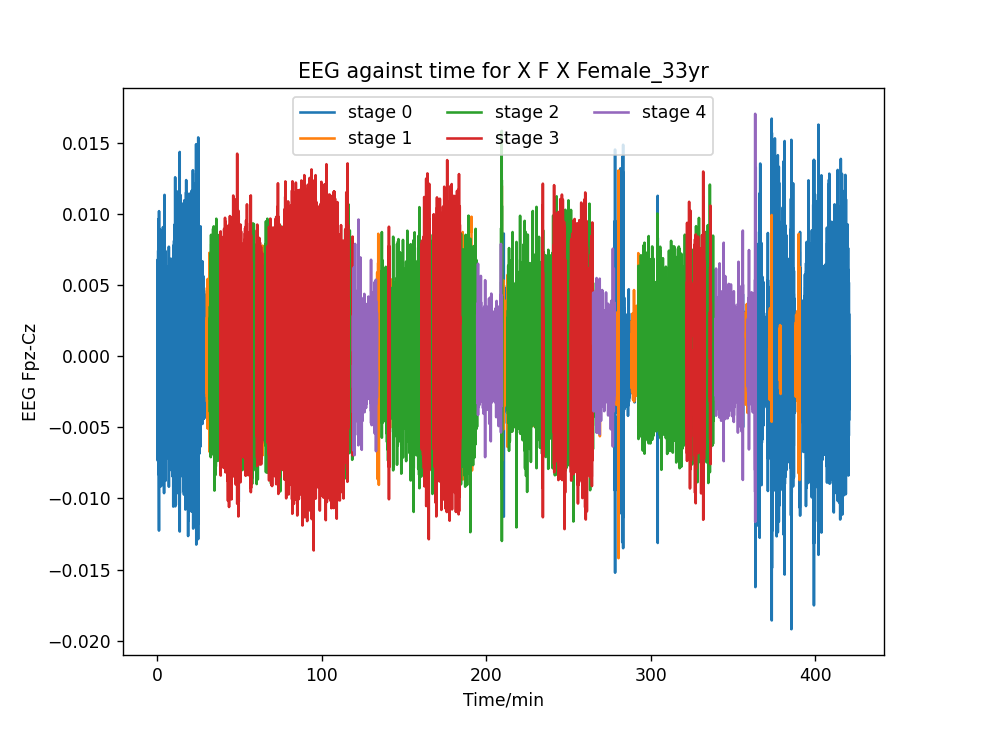

In [81]:
plot_signal_for_one_sleep(data_list[0])

In [82]:
compare_signals_of_different_stages(signal_of_stages, 10)

In [83]:
plot_average_signal_amplitudes_of_different_stages(average_amplitudes_of_stages)

In [84]:
plot_amplitude_distributions(amplitude_distribution_of_stages)

In [85]:
plot_average_fft_magnitudes(freqs, average_fft_magnitudes_of_stages)

In [86]:
plot_average_fft_magnitudes_of_brain_waves(brain_wave_labels, average_fft_magnitudes_of_brain_waves_of_stages)

In [87]:
compare_dwt_coefficients_of_stages(signal_of_stages, 0)

In [88]:
plot_average_dwt_amplitude_of_stages(dwt_coefficients)

In [89]:
plot_distribution_of_dwt_magnitude(dwt_coefficients)